# Homework 6 (more of a tutorial, really)

As I was browsing through Kaggle the other day, I came upon a brand new dataset from the University of Puerto Rico, which contains images of bees entering their hive.  The task is to determine automatically which bees are carrying pollen.  Your job will be to develop a convolutional neural network that performs this task.  

## 1. Load Data (0 pts)

First, we need to load the bee data, which is included along with this homework.  Fortunately, the authors of the Kaggle dataset provided a nice set of files which will do this for us, which I have reproduced below

In [1]:
import glob, os 
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
path="images/"
imlist= glob.glob(os.path.join(path, '*.jpg'))

In [3]:
def dataset(file_list,size=(300,180),flattened=False):
    data = []
    for i, file in enumerate(file_list):
        image = io.imread(file)
        image = transform.resize(image, size, mode='constant')
        if flattened:
            image = image.flatten()

        data.append(image)

    labels = [1 if f.split("/")[-1][0] == 'P' else 0 for f in file_list]

    return np.array(data), np.array(labels)

In [4]:
# Load the dataset (may take a few seconds)
X,y=dataset(imlist)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

/Users/williamcook/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [5]:
# X has the following structure: X[imageid, y,x,channel]
print('X: ',X.shape)  # data
print('y: ',y.shape)  # target

print('Class 0: ',sum(y==0))
print('Class 1: ',sum(y==1))
print('Total  : ',len(y))

X:  (714, 300, 180, 3)
y:  (714,)
Class 0:  345
Class 1:  369
Total  :  714


We can plot a couple of the images below.  If you check out a couple of these, you will see that the visible difference when bees carry pollen is the presence of large fluffy balls of pollen on their back legs.

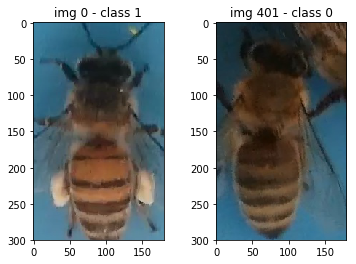

In [6]:
fig, axes = plt.subplots(1,2)
k=0
plt.sca(axes[0])
plt.imshow(X[k])
plt.title('img {} - class {}'.format(k, y[k]))

k=401
plt.sca(axes[1])
plt.imshow(X[k])
plt.title('img {} - class {}'.format(k, y[k]));

## 2. A convolutional network architecture for bee classification (40 pts)

**Implement a 2D convolutional neural network using Keras.  You are free to choose whatever network architecture you like.**

You can find all the relevant syntax for implementing such a network [here](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py), the Keras convnet example for MNIST.

*(For the sake of comparison, I will share the one that I used:*

Layer 1: 5x5 convolution layer with 24 kernels and a relu activation function

Layer 2: 4x4 Max-pooling layer

Layer 3: 5x5 convolution layer with 24 kernels and a relu activation function

Layer 4: 4x4 Max-pooling layer

Layer 5: 5x5 convolution layer with 24 kernels and a relu activation function

Layer 6: 4x4 Max-pooling layer

Layer 7: Flattening layer

Layer 8: Dropout layer with 0.2 dropout probability

Layer 9: 1 node sigmoid layer


In [48]:
import keras
import keras.models as km
import keras.layers as kl

import numpy as np

input_shape = ((300,180,3))

model = km.Sequential()
model.add(kl.Conv2D(24, kernel_size=(5, 5), #L1
                 activation='relu',
input_shape=input_shape))
model.add(kl.MaxPooling2D(pool_size=(4, 4))) #L2      
model.add(kl.Conv2D(24, kernel_size=(5, 5), #L3
                 activation='relu'))
model.add(kl.MaxPooling2D(pool_size=(4, 4))) #L4      
model.add(kl.Conv2D(24, kernel_size=(5, 5), #L5
                 activation='relu'))
model.add(kl.MaxPooling2D(pool_size=(4, 4))) #L6
model.add(kl.Flatten())                      #L7
model.add(kl.Dropout(0.1))                   #L8
model.add(kl.Dense(2, activation='softmax')) #L9


## 3. Fitting the CNN to data (20 pts)

Compile your model, using a binary crossentropy loss function and an optimizer of your choosing (RMSprop worked well for me).  Select a batch size and number of epochs, and fit your model to the training data, while also keeping track of the test set accuracy.

**Plot the training and test accuracy of your model at each epoch.  Comment on whether you think the model is being overfit.**

In [8]:
from keras.utils import to_categorical

# I Had to do this to make stuff run
y_train_new = to_categorical(y_train)
y_test_new = to_categorical(y_test)


In [10]:

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

batch_size = 24
epochs= 12
history = model.fit(X_train, y_train_new,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test,y_test_new))

Train on 571 samples, validate on 143 samples
Epoch 1/12
571/571 [==============================] - 21s 37ms/step - loss: 0.6614 - acc: 0.6182 - val_loss: 0.6486 - val_acc: 0.6224
Epoch 2/12
571/571 [==============================] - 22s 39ms/step - loss: 0.5573 - acc: 0.7215 - val_loss: 0.5343 - val_acc: 0.7343
Epoch 3/12
571/571 [==============================] - 23s 41ms/step - loss: 0.4959 - acc: 0.7933 - val_loss: 0.5285 - val_acc: 0.7063
Epoch 4/12
571/571 [==============================] - 29s 51ms/step - loss: 0.4488 - acc: 0.8056 - val_loss: 0.4601 - val_acc: 0.7972
Epoch 5/12
571/571 [==============================] - 22s 38ms/step - loss: 0.4448 - acc: 0.8004 - val_loss: 0.4278 - val_acc: 0.7483
Epoch 6/12
571/571 [==============================] - 22s 39ms/step - loss: 0.3676 - acc: 0.8406 - val_loss: 0.4643 - val_acc: 0.7692
Epoch 7/12
571/571 [==============================] - 24s 42ms/step - loss: 0.3448 - acc: 0.8476 - val_loss: 0.5491 - val_acc: 0.7203
Epoch 8/12
571/5

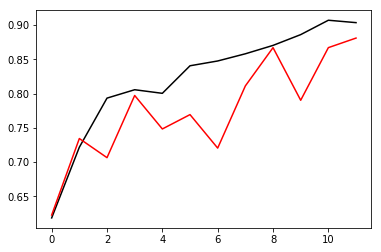

In [12]:
#! Plot test and training accuracy (note that the history.history object is a dictionary containing relevant info)
h = history.history
plt.plot(h['acc'],'k-', label="Training Acc")
plt.plot(h['val_acc'],'r', label="Test Acc")
plt.show()

## 4. Model evaluation (20 pts)

Now that you have a trained model, make a prediction for the test set (model.predict is a useful function for this).  **Compute and display a confusion matrix.  Select and display an example from the test set of a true positive, a true negative, a false positive, and a false negative.  Speculate on the reasons behind misclassification for images that your model predicted incorrectly**.

[[71  4]
 [13 55]]
Classification accuracy:  0.8811188811188811


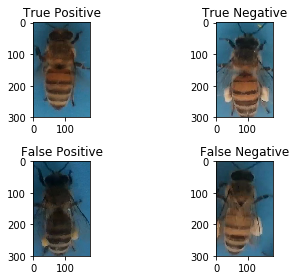

In [45]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(X_test)
pred_vec = np.round(predictions[:,1])
conf_m = confusion_matrix(y_test,pred_vec)
accuracy = np.diagonal(conf_m).sum()/conf_m.sum()
print(conf_m)
print("Classification accuracy: ",accuracy)

true_positive = (pred_vec+y_test).argmax()
true_negative = (pred_vec+y_test).argmin()
false_positive = np.logical_and(pred_vec == 1, y_test == 0).argmax()
false_negative = np.logical_and(pred_vec == 0, y_test == 1).argmax()

fig, axes = plt.subplots(2,2)

plt.sca(axes[0,0])
plt.imshow(X[true_positive])
plt.title("True Positive");

plt.sca(axes[0,1])
plt.imshow(X[true_negative])
plt.title("True Negative");

plt.sca(axes[1,0])
plt.imshow(X[false_positive])
plt.title("False Positive");

plt.sca(axes[1,1])
plt.imshow(X[false_negative])
plt.title("False Negative");
plt.tight_layout()

## Rationale

In the *false positive* category, the bee's wings are colored in such a way that it looks very similar to pollen. It's possible some bee's wing color will cause the filter to give inaccurate results. In the *false negative* category, a bee is not entirely in the frame. This has confused the filter because it looks at the knees to determine if there is pollen, and only one knee is visible.